# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [120]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [121]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [122]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [123]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [124]:
# define a function to load json file to a dataframe
def load_json_to_df(file_path):
    """
    Load a JSON file and convert it to a pandas DataFrame.
    
    Args:
        file_path (str): Path to the JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the JSON data.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data)

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [125]:
# read the json file by giving the file path and create a dataframe
def read_json_file(file_path):
    """
    Read a JSON file and return its content as a DataFrame.
    
    Args:
        file_path (str): Path to the JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the JSON data.
    """
    df = load_json_to_df(file_path)
    return df

df = read_json_file('ingredient_and_quantity.json')


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [126]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [127]:
# print the dimensions of dataframe - df
print(f"DataFrame dimensions: {df.shape[0]} rows, {df.shape[1]} columns")

DataFrame dimensions: 285 rows, 2 columns


In [128]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [129]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
def split_input_pos(df):
    """
    Split the 'input' and 'pos' columns into separate tokens.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input' and 'pos' columns.
        
    Returns:
        pd.DataFrame: DataFrame with 'input_tokens' and 'pos_tokens' columns.
    """
    df['input_tokens'] = df['input'].apply(lambda x: x.split())
    df['pos_tokens'] = df['pos'].apply(lambda x: x.split())
    return df
# Tokenize input
df = split_input_pos(df)




In [130]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [131]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
def create_length_columns(df):
    """
    Create length columns for 'input_tokens' and 'pos_tokens'.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens' columns.
        
    Returns:
        pd.DataFrame: DataFrame with 'input_length' and 'pos_length' columns.
    """
    df['input_length'] = df['input_tokens'].apply(len)
    df['pos_length'] = df['pos_tokens'].apply(len)
    return df

# Create length columns
df = create_length_columns(df)

In [132]:
# check for the equality of input_length and pos_length in the dataframe
df['lengths_equal'] = df['input_length'] == df['pos_length']
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length  lengths_equal
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31           True
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashe

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [133]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Print all unique POS labels in the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'pos' column.
    """
    pos_labels = set()
    for pos_list in df['pos']:
        pos_labels.update(pos_list.split())
    print("Unique POS labels:", pos_labels)
# Call the unique_labels function to print all the unique pos labels in the recipe
unique_labels(df)

Unique POS labels: {'unit', 'quantity', 'ingredient'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [134]:
# drop the irrelevant recipe data
df = df[df['lengths_equal']]

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [135]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [136]:
# validate the input length and pos length as input_length and pos_length
def validate_lengths(df):
    """
    Validate that 'input_length' and 'pos_length' are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input_length' and 'pos_length' columns.
        
    Returns:
        bool: True if lengths are equal, False otherwise.
    """
    return all(df['input_length'] == df['pos_length'])
# Validate lengths
if validate_lengths(df):
    print("Input length and POS length are equal for all rows.")
else:
    print("There are discrepancies between input length and POS length.")

Input length and POS length are equal for all rows.


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [137]:
# split the dataset into training and validation sets
def split_dataset(df, test_size=0.2, random_state=42):
    """
    Split the DataFrame into training and validation sets.
    
    Args:
        df (pd.DataFrame): DataFrame to be split.
        test_size (float): Proportion of the dataset to include in the validation set.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        tuple: Training and validation DataFrames.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df, val_df
# Split the dataset
train_df, val_df = split_dataset(df)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [138]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos                                                                                                                                                                                                                                                                                                                                                                     input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  pos_tokens  input_length  pos_length  lengths_equal
89                                                                                                                                                                     1/2 cup Sooji Semolina Rava teaspoon Ghee 3 cups Milk 3/4 Sugar 5 Saffron strands 1 Cardamom Elaichi Pods Seeds Cashew nuts Raisins Mixed dry fruits chopped                                                                                                                                                                                                                               quantity unit ingredient ingredient ingredient unit ingredient quantity unit ingredient quantity ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                                                                                         [1/2, cup, Sooji, Semolina, Rava, teaspoon, Ghee, 3, cups, Milk, 3/4, Sugar, 5, Saffron, strands, 1, Cardamom, Elaichi, Pods, Seeds, Cashew, nuts, Raisins, Mixed, dry, fruits, chopped]                                                                                                                                                                                                                                                    [quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            27          27           True
140                                                                                                                                                                                                                                         50 grams Wheat Grass Powder 1/2 teaspoon Black pepper powder 1 Cumin Jeera Lemon juiced                                                                                                                                                                                                                                                                                                                                                         quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingred

In [139]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length  lengths_equal
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15           True
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 C

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [140]:
# extract the training and validation sets by taking input_tokens and pos_tokens
def extract_tokens(df):
    """
    Extract 'input_tokens' and 'pos_tokens' from the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens' columns.
        
    Returns:
        tuple: Lists of input tokens and POS tokens.
    """
    input_tokens = df['input_tokens'].tolist()
    pos_tokens = df['pos_tokens'].tolist()
    return input_tokens, pos_tokens
# Extract tokens from training and validation sets
train_input_tokens, train_pos_tokens = extract_tokens(train_df)
val_input_tokens, val_pos_tokens = extract_tokens(val_df)

In [141]:
# validate the shape of training and validation samples
def validate_shapes(train_tokens, val_tokens):
    """
    Validate the shapes of training and validation token lists.
    
    Args:
        train_tokens (list): List of training tokens.
        val_tokens (list): List of validation tokens.
        
    Returns:
        bool: True if shapes are valid, False otherwise.
    """
    return len(train_tokens) > 0 and len(val_tokens) > 0
# Validate shapes
if validate_shapes(train_input_tokens, val_input_tokens):
    print("Training and validation token lists are valid.")
else:
    print("Training or validation token lists are empty. Please check the data.")

Training and validation token lists are valid.


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [142]:
# Display the number of unique labels present in y_train
def unique_labels_count(pos_tokens):
    """
    Count the number of unique POS labels in the token list.
    
    Args:
        pos_tokens (list): List of POS tokens.
        
    Returns:
        int: Number of unique POS labels.
    """
    unique_labels = set()
    for pos_list in pos_tokens:
        unique_labels.update(pos_list)
    return len(unique_labels)   
# Count unique labels in training and validation sets
train_unique_labels_count = unique_labels_count(train_pos_tokens)
val_unique_labels_count = unique_labels_count(val_pos_tokens)
print(f"Number of unique POS labels in training set: {train_unique_labels_count}")
print(f"Number of unique POS labels in validation set: {val_unique_labels_count}")

Number of unique POS labels in training set: 3
Number of unique POS labels in validation set: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [143]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flatten a nested list.
    
    Args:
        nested_list (list): List of lists to be flattened.
        
    Returns:
        list: Flattened list.
    """
    return [item for sublist in nested_list for item in sublist]
# Flatten input and POS tokens
train_flat_input_tokens = flatten_list(train_input_tokens)
train_flat_pos_tokens = flatten_list(train_pos_tokens)
val_flat_input_tokens = flatten_list(val_input_tokens)
val_flat_pos_tokens = flatten_list(val_pos_tokens)

In [144]:
train_flat_input_tokens

['1/2',
 'cup',
 'Sooji',
 'Semolina',
 'Rava',
 'teaspoon',
 'Ghee',
 '3',
 'cups',
 'Milk',
 '3/4',
 'Sugar',
 '5',
 'Saffron',
 'strands',
 '1',
 'Cardamom',
 'Elaichi',
 'Pods',
 'Seeds',
 'Cashew',
 'nuts',
 'Raisins',
 'Mixed',
 'dry',
 'fruits',
 'chopped',
 '50',
 'grams',
 'Wheat',
 'Grass',
 'Powder',
 '1/2',
 'teaspoon',
 'Black',
 'pepper',
 'powder',
 '1',
 'Cumin',
 'Jeera',
 'Lemon',
 'juiced',
 '2',
 'cups',
 'Potatoes',
 'Aloo',
 '1',
 'Tomatoes',
 'finely',
 'chopped',
 '1-1/2',
 'tablespoon',
 'Ginger',
 'grated',
 'ground',
 'Green',
 'Chillies',
 'slit',
 'tablespoons',
 'Kasuri',
 'Methi',
 'Dried',
 'Fenugreek',
 'Leaves',
 '1/2',
 'teaspoon',
 'Fennel',
 'seeds',
 'Saunf',
 'Cumin',
 'Jeera',
 'Seeds',
 'Coriander',
 'Powder',
 'Dhania',
 'Red',
 'Chilli',
 'powder',
 'Turmeric',
 'Haldi',
 'Garam',
 'masala',
 'teaspoons',
 'Amchur',
 'Dry',
 'Mango',
 'Ghee',
 'Salt',
 'to',
 'taste',
 '1',
 'cup',
 'Rice',
 '1/2',
 'Yellow',
 'Moong',
 'Dal',
 'Mint',
 'Leave

In [145]:
train_flat_pos_tokens

['quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'quantity',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient'

In [146]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [147]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Extract and validate tokens from the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens' columns.
        dataset_name (str): Name of the dataset (e.g., 'Training', 'Validation').
        
    Returns:
        None
    """
    input_tokens = flatten_list(df['input_tokens'].tolist())
    pos_tokens = flatten_list(df['pos_tokens'].tolist())
    
    if len(input_tokens) == len(pos_tokens):
        print(f"{dataset_name} set tokens are valid.")
        print(f"First 10 {dataset_name} input tokens: {input_tokens[:10]}")
        print(f"First 10 {dataset_name} POS tokens: {pos_tokens[:10]}")
    else:
        print(f"Mismatch in token lengths for {dataset_name} set.")
# Call the function for training and validation sets
extract_and_validate_tokens(train_df, 'Training')
extract_and_validate_tokens(val_df, 'Validation')

Training set tokens are valid.
First 10 Training input tokens: ['1/2', 'cup', 'Sooji', 'Semolina', 'Rava', 'teaspoon', 'Ghee', '3', 'cups', 'Milk']
First 10 Training POS tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient']
Validation set tokens are valid.
First 10 Validation input tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 Validation POS tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


In [148]:
# extract the tokens and its pos tags
def extract_tokens_and_pos(df):
    """
    Extract tokens and their corresponding POS tags from the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens' columns.
        
    Returns:
        list: List of tuples containing input tokens and their corresponding POS tags.
    """
    return [(input_token, pos_token) for input_token, pos_token in zip(df['input_tokens'], df['pos_tokens'])]
# Extract tokens and POS tags from training and validation sets
train_tokens_and_pos = extract_tokens_and_pos(train_df)
val_tokens_and_pos = extract_tokens_and_pos(val_df)
print(f"Number of training samples: {len(train_tokens_and_pos)}")
print(f"Number of validation samples: {len(val_tokens_and_pos)}")

print(train_tokens_and_pos [:5])  # Display first 5 training samples
print(val_tokens_and_pos [:5])  # Display first 5 validation samples

Number of training samples: 224
Number of validation samples: 56
[(['1/2', 'cup', 'Sooji', 'Semolina', 'Rava', 'teaspoon', 'Ghee', '3', 'cups', 'Milk', '3/4', 'Sugar', '5', 'Saffron', 'strands', '1', 'Cardamom', 'Elaichi', 'Pods', 'Seeds', 'Cashew', 'nuts', 'Raisins', 'Mixed', 'dry', 'fruits', 'chopped'], ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']), (['50', 'grams', 'Wheat', 'Grass', 'Powder', '1/2', 'teaspoon', 'Black', 'pepper', 'powder', '1', 'Cumin', 'Jeera', 'Lemon', 'juiced'], ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient']), (['2', 'c

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [149]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
# structure is [(['token1', 'token2'], ['ingredient', 'unit']), ...]

# categorize token function will take the argument of train_flat_input_tokens and train_flat_pos_tokens and return the ingredients, units and quantities

def categorize_tokens(token,pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities.
    
    Args:
        token (list): List of input tokens.
        pos_tags (list): List of POS tags corresponding to the input tokens.
        
    Returns:
        tuple: Lists of ingredients, units, and quantities.
    """
    categorized = {'ingredients': [], 'units': [], 'quantities': []}
    
    for t, pos in zip(token, pos_tags):
        if pos.lower() == 'ingredient':
            categorized['ingredients'].append(t)
        elif pos.lower() == 'unit':
            categorized['units'].append(t)
        elif pos.lower() == 'quantity':
            categorized['quantities'].append(t)
    
    # Validate that all lists contain the expected labels
    if not all(key in categorized for key in ['ingredients', 'units', 'quantities']):
        return [], [], []
    
    return categorized['ingredients'], categorized['units'], categorized['quantities']


In [150]:
#  call the function to categorise the labels into respective list

train_ingredients, train_units, train_quantities = categorize_tokens(train_flat_input_tokens, train_flat_pos_tokens)
val_ingredients, val_units, val_quantities = categorize_tokens(val_flat_input_tokens, val_flat_pos_tokens)


In [151]:
train_ingredients[:5]  # Display first 5 ingredients from training set


['Sooji', 'Semolina', 'Rava', 'Ghee', 'Milk']

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [152]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
 
from collections import Counter
def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Get the top N most frequent items from a list.
    
    Args:
        item_list (list): List of items to analyze.
        pos_label (str): POS label for the items (e.g., 'Ingredient', 'Unit', 'Quantity').
        dataset_name (str): Name of the dataset (e.g., 'Training', 'Validation').
        top_n (int): Number of top items to return.
        
    Returns:
        pd.DataFrame: DataFrame containing the top N items and their counts.
    """
    item_counter = Counter(item_list)
    top_items = item_counter.most_common(top_n)
    return pd.DataFrame(top_items, columns=[f'{pos_label}', 'count'])


In [153]:
# get the top ingredients which are frequently seen in the recipe
train_top_ingredients = get_top_frequent_items(train_ingredients, 'ingredient', 'Training')
val_top_ingredients = get_top_frequent_items(val_ingredients, 'ingredient', 'Validation')
print("Top ingredients in Training set:")
print(train_top_ingredients)
print("\nTop ingredients in Validation set:")
print(val_top_ingredients)

Top ingredients in Training set:
  ingredient  count
0     powder    148
1       Salt    116
2      seeds    103
3        Oil     94
4    chopped     93
5        Red     93
6      Green     91
7     Chilli     89
8  Coriander     82
9  Sunflower     75

Top ingredients in Validation set:
  ingredient  count
0     powder     35
1       Salt     33
2        Oil     28
3        Red     27
4      Green     24
5     Chilli     24
6    chopped     22
7      seeds     22
8     Leaves     20
9     Garlic     17


In [154]:
# get the top units which are frequently seen in the recipe
train_top_units = get_top_frequent_items(train_units, 'unit', 'Training')
val_top_units = get_top_frequent_items(val_units, 'unit', 'Validation')
print("Top units in Training set:")
print(train_top_units)
print("\nTop units in Validation set:")
print(val_top_units)

Top units in Training set:
          unit  count
0     teaspoon    182
1          cup    149
2   tablespoon    109
3        grams     75
4  tablespoons     70
5         inch     59
6         cups     56
7        sprig     48
8    teaspoons     45
9       cloves     45

Top units in Validation set:
          unit  count
0          cup     44
1     teaspoon     39
2  tablespoons     23
3   tablespoon     22
4         cups     18
5        sprig     14
6         inch     13
7    teaspoons     12
8       cloves     10
9        grams      7


In [155]:
# get the top quantities which are frequently seen in the recipe
train_top_quantities = get_top_frequent_items(train_quantities, 'quantity', 'Training')
val_top_quantities = get_top_frequent_items(val_quantities, 'quantity', 'Validation')
print("Top quantities in Training set:")
print(train_top_quantities)
print("\nTop quantities in Validation set:")
print(val_top_quantities)

Top quantities in Training set:
  quantity  count
0        1    218
1        2    173
2      1/2    165
3      1/4    114
4        3     73
5        4     65
6    1-1/2     24
7      200     24
8        5     23
9      500     20

Top quantities in Validation set:
  quantity  count
0        1     51
1        2     48
2      1/2     38
3        3     25
4      1/4     25
5        4     22
6    1-1/2     10
7      3/4      9
8        6      8
9        5      5


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [156]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """
    Plot the top items using a bar chart.
    
    Args:
        top_items (pd.DataFrame): DataFrame containing top items and their counts.
        label (str): Label for the items (e.g., 'ingredient', 'unit').
        dataset_name (str): Name of the dataset (e.g., 'Training', 'Validation').
        
    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y=label, data=top_items)
    plt.title(f'Top {label}s in {dataset_name} Set')
    plt.xlabel('Count')
    plt.ylabel(label.capitalize())
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



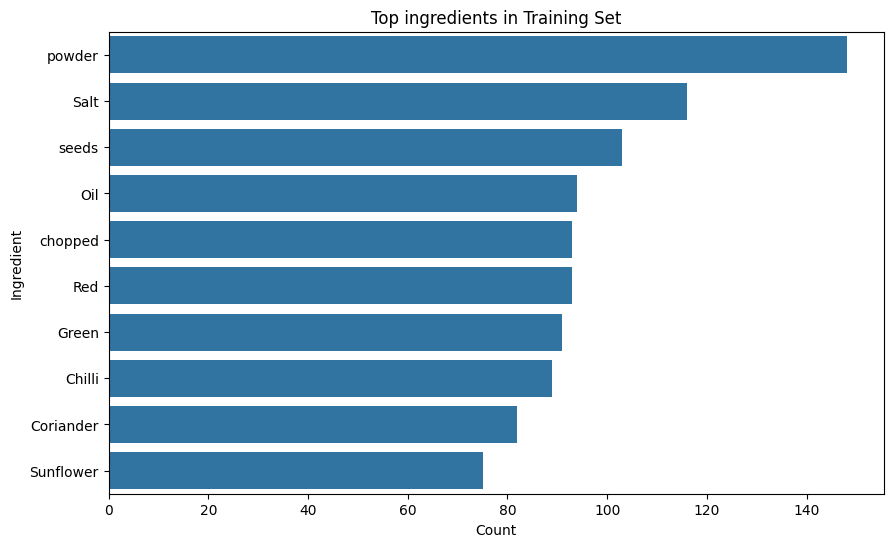

In [157]:
# plot the top frequent ingredients in training data
plot_top_items(train_top_ingredients, 'ingredient', 'Training')

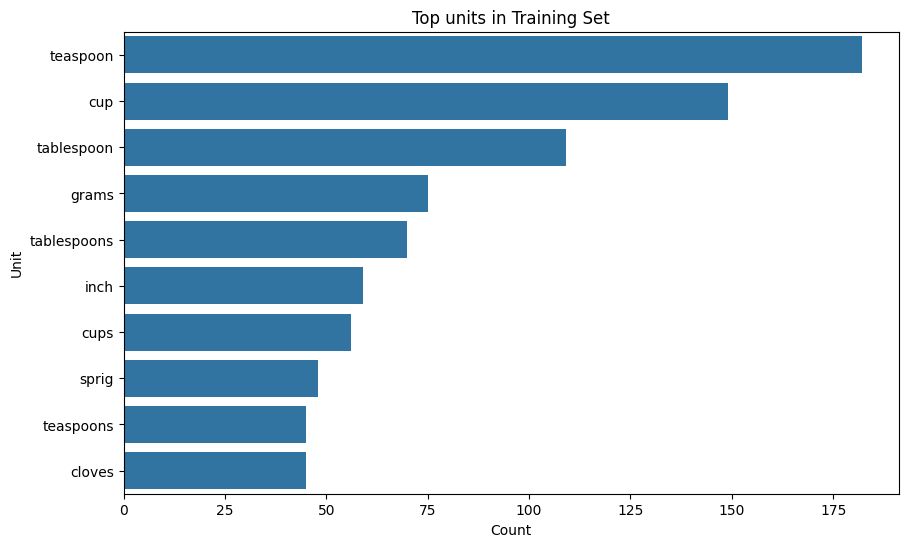

In [158]:
# plot the top frequent units in training data
plot_top_items(train_top_units, 'unit', 'Training')

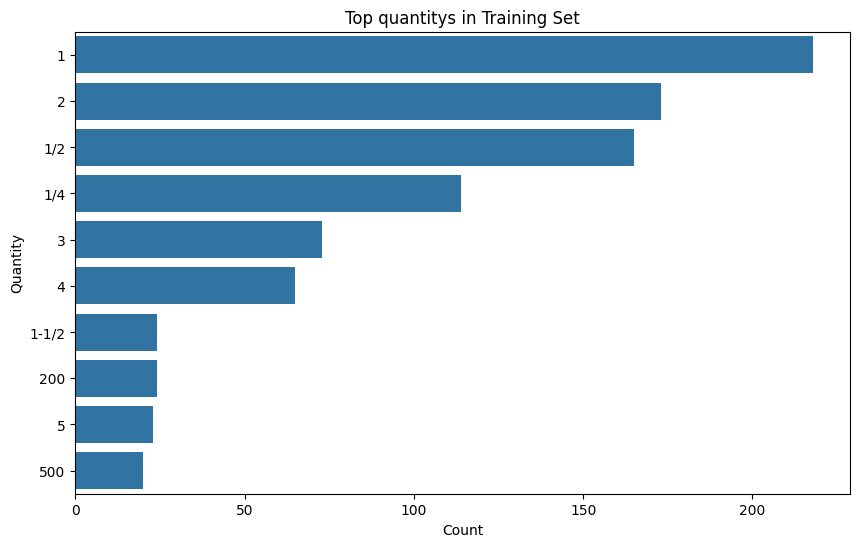

In [159]:
plot_top_items(train_top_quantities, 'quantity', 'Training')


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [160]:
# initialise the dataset_name


In [161]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [162]:
# plot the top frequent ingredients in validation data


In [163]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [164]:
# define unit and quantity keywords along with quantity pattern
def get_unit_and_quantity_keywords():
    """
    Get predefined unit and quantity keywords along with a regex pattern for quantities.
    
    Returns:
        tuple: A tuple containing lists of unit keywords, quantity keywords, and a regex pattern for quantities.
    """
    unit_keywords = ['cup', 'teaspoon', 'tablespoon', 'ounce', 'pound', 'gram', 'kilogram', 'liter', 'milliliter']
    quantity_keywords = ['pinch', 'dash', 'splash', 'handful']
    quantity_pattern = r'^\d+(\.\d+)?\s*(cup|teaspoon|tablespoon|ounce|pound|gram|kilogram|liter|milliliter)?$'
    
    return unit_keywords, quantity_keywords, quantity_pattern
# Get unit and quantity keywords
unit_keywords, quantity_keywords, quantity_pattern = get_unit_and_quantity_keywords()

unit_keywords

['cup',
 'teaspoon',
 'tablespoon',
 'ounce',
 'pound',
 'gram',
 'kilogram',
 'liter',
 'milliliter']

In [165]:
# load spaCy model
def load_spacy_model(model_name='en_core_web_sm'):
    """
    Load a spaCy model.
    
    Args:
        model_name (str): Name of the spaCy model to load.
        
    Returns:
        spacy.language.Language: Loaded spaCy model.
    """
    nlp = spacy.load(model_name)
    return nlp
# Load spaCy model
nlp = load_spacy_model()

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [166]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
def word2features(sent, i):
    """
    Extract features for a specific token in a sentence for CRF training.
    
    Args:
        sent (list): List of tokens in the sentence.
        i (int): Index of the token to extract features for.
        
    Returns:
        dict: A dictionary of features for the specified token.
    """
    import re
    from fractions import Fraction
    
    # Enhanced unit and quantity keywords
    extended_unit_keywords = unit_keywords + [
        'tsp', 'tbsp', 'oz', 'lb', 'kg', 'g', 'ml', 'l',  # Abbreviations
        'cups', 'teaspoons', 'tablespoons', 'ounces', 'pounds',  # Plurals
        'grams', 'kilograms', 'liters', 'milliliters',
        'inch', 'inches', 'cm', 'centimeter', 'centimeters',
        'piece', 'pieces', 'slice', 'slices', 'bunch', 'bunches',
        'sprig', 'sprigs', 'clove', 'cloves', 'stick', 'sticks',
        'unit', 'units'
    ]
    
    extended_quantity_keywords = quantity_keywords + [
        'half', 'quarter', 'few', 'some', 'little', 'bit',
        'fistful', 'handful', 'bunch', 'small', 'medium', 'large',
        'big', 'tiny', 'whole'
    ]
    
    # Enhanced quantity pattern for better matching
    enhanced_quantity_pattern = r'''
        ^(?:
            \d+[-/]\d+(?:/\d+)?|     # Fractions: 1/2, 2-1/2, 1-1/2
            \d+\.\d+|                # Decimals: 3.14, 0.5
            \d+|                     # Whole numbers: 1, 2, 10
            (?:half|quarter|few|some|little|bit|handful|pinch|dash|splash)
        )(?:\s*(?:cup|teaspoon|tablespoon|tsp|tbsp|ounce|oz|pound|lb|gram|g|kilogram|kg|liter|l|milliliter|ml)s?)?$
    '''
    
    # Helper functions for pattern matching
    def is_quantity_match(text):
        """Check if text matches quantity pattern or keywords."""
        if re.match(quantity_pattern, text, re.IGNORECASE | re.VERBOSE):
            return True
        if text.lower() in extended_quantity_keywords:
            return True
        return False
    
    def is_numeric_pattern(text):
        """Check if text is a pure number."""
        try:
            float(text)
            return True
        except ValueError:
            return False
    
    def is_fraction_pattern(text):
        """Check for fractions like '1/2', '2-1/2'."""
        fraction_patterns = [
            r'^\d+/\d+$',           # Simple fractions: 1/2
            r'^\d+-\d+/\d+$',       # Complex fractions: 2-1/2
            r'^\d+-\d+$'            # Hyphenated numbers: 1-2
        ]
        return any(re.match(pattern, text) for pattern in fraction_patterns)
    
    def is_decimal_pattern(text):
        """Check for decimal numbers."""
        decimal_pattern = r'^\d+\.\d+$'
        return bool(re.match(decimal_pattern, text))
    
    # Process the entire sentence with spaCy
    sentence_text = ' '.join(sent)
    doc = nlp(sentence_text)
    
    # Handle tokenization mismatch between sent and spaCy
    if i >= len(doc):
        # Fallback: use raw token if spaCy tokenization differs
        current_token_text = sent[i]
        token = None
    else:
        token = doc[i]
        current_token_text = token.text
    
    # Initialize features dictionary
    features = {}
    
    # --- Core Features (16 features) ---
    features['bias'] = 1.0  # Constant feature
    features['token'] = current_token_text.lower()
    
    if token:
        features['lemma'] = token.lemma_.lower()
        features['pos_tag'] = token.pos_
        features['tag'] = token.tag_
        features['dep'] = token.dep_
        features['shape'] = token.shape_
        features['is_stop'] = token.is_stop
        features['is_punct'] = token.is_punct
    else:
        # Fallback for tokenization mismatch
        features['lemma'] = current_token_text.lower()
        features['pos_tag'] = 'UNKNOWN'
        features['tag'] = 'UNKNOWN'
        features['dep'] = 'UNKNOWN'
        features['shape'] = 'UNKNOWN'
        features['is_stop'] = False
        features['is_punct'] = not current_token_text.isalnum()
    
    # Character-based boolean features
    features['is_digit'] = current_token_text.isdigit()
    features['has_digit'] = any(c.isdigit() for c in current_token_text)
    features['has_alpha'] = any(c.isalpha() for c in current_token_text)
    features['hyphenated'] = '-' in current_token_text
    features['slash_present'] = '/' in current_token_text
    features['is_title'] = current_token_text.istitle()
    features['is_upper'] = current_token_text.isupper()
    
    # --- Improved Quantity and Unit Detection (7 features) ---
    features['is_quantity'] = is_quantity_match(current_token_text)
    features['is_unit'] = current_token_text.lower() in extended_unit_keywords
    features['is_numeric'] = is_numeric_pattern(current_token_text)
    features['is_fraction'] = is_fraction_pattern(current_token_text)
    features['is_decimal'] = is_decimal_pattern(current_token_text)
    
    # Context words (preceding and following)
    features['preceding_word'] = sent[i-1] if i > 0 else '<BOS>'
    features['following_word'] = sent[i+1] if i < len(sent)-1 else '<EOS>'
    
    # --- Contextual Features (8 features) ---
    
    # Previous token features
    if i > 0:
        prev_token_text = sent[i-1]
        features['prev_token'] = prev_token_text.lower()
        features['prev_is_quantity'] = is_quantity_match(prev_token_text)
        features['prev_is_digit'] = prev_token_text.isdigit()
        features['BOS'] = False
    else:
        features['prev_token'] = '<BOS>'
        features['prev_is_quantity'] = False
        features['prev_is_digit'] = False
        features['BOS'] = True
    
    # Next token features
    if i < len(sent) - 1:
        next_token_text = sent[i+1]
        features['next_token'] = next_token_text.lower()
        features['next_is_unit'] = next_token_text.lower() in extended_unit_keywords
        # next_is_ingredient: not a unit and not a quantity
        features['next_is_ingredient'] = not (
            next_token_text.lower() in extended_unit_keywords or 
            is_quantity_match(next_token_text)
        )
        features['EOS'] = False
    else:
        features['next_token'] = '<EOS>'
        features['next_is_unit'] = False
        features['next_is_ingredient'] = False
        features['EOS'] = True
    
    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [167]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Extract features for all tokens in a sentence.
    
    Args:
        sent (list): List of tokens in the sentence.
        
    Returns:
        list: List of feature dictionaries for each token in the sentence.
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [168]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
def convert_to_features(tokens):
    """
    Convert a list of tokenized sentences into feature sets.
    
    Args:
        tokens (list): List of tokenized sentences.
        
    Returns:
        list: List of feature dictionaries for each sentence.
    """
    return [sent2features(sent) for sent in tokens]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [169]:
# Convert labels into list as y_train_labels and y_val_labels
def convert_to_labels(tokens_and_pos):
    """
    Convert a list of tokenized sentences and their POS tags into label lists.
    
    Args:
        tokens_and_pos (list): List of tuples containing tokenized sentences and their POS tags.
        
    Returns:
        list: List of label lists for each sentence.
    """
    return [[pos for pos in pos_list] for _, pos_list in tokens_and_pos]
# Convert training and validation tokens into features and labels
X_train_features = convert_to_features(train_input_tokens)
X_val_features = convert_to_features(val_input_tokens)
y_train_labels = convert_to_labels(train_tokens_and_pos)
y_val_labels = convert_to_labels(val_tokens_and_pos)

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [170]:
# print the length of train features and labels
train_tokens_and_pos = train_tokens_and_pos[:1000]  # Limit to first 1000 samples for demonstration
val_tokens_and_pos = val_tokens_and_pos[:1000]  # Limit to first 1000 samples for demonstration
print(f"Number of training samples: {len(X_train_features)}")
print(f"Number of training labels: {len(y_train_labels)}")

Number of training samples: 224
Number of training labels: 224


In [171]:
# print the length of validation features and labels
print(f"Number of validation samples: {len(X_val_features)}")
print(f"Number of validation labels: {len(y_val_labels)}")

Number of validation samples: 56
Number of validation labels: 56


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [172]:
# Flatten labels in y_train
def flatten_labels(y_labels):
    """
    Flatten a list of label lists into a single list.
    
    Args:
        y_labels (list): List of label lists.
        
    Returns:
        list: Flattened list of labels.
    """
    return [label for sublist in y_labels for label in sublist]

# Flatten training and validation labels
y_train_flat = flatten_labels(y_train_labels)
y_val_flat = flatten_labels(y_val_labels)


In [173]:
y_train_flat

['quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'quantity',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient'

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [174]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
def count_label_frequencies(y_labels):
    """
    Count the frequency of each label in a list of labels.
    
    Args:
        y_labels (list): List of labels.
        
    Returns:
        tuple: A dictionary of label frequencies and the total number of samples.
    """
    label_counts = Counter(y_labels)
    total_samples = sum(label_counts.values())
    return label_counts, total_samples
# Count label frequencies in training and validation sets
train_label_counts, train_total_samples = count_label_frequencies(y_train_flat)
val_label_counts, val_total_samples = count_label_frequencies(y_val_flat)
# Print label frequencies and total samples
print("Training label frequencies:", train_label_counts)
print("Total training samples:", train_total_samples)
print("Validation label frequencies:", val_label_counts)
print("Total validation samples:", val_total_samples)

Training label frequencies: Counter({'ingredient': 5978, 'quantity': 1101, 'unit': 929})
Total training samples: 8008
Validation label frequencies: Counter({'ingredient': 1452, 'quantity': 290, 'unit': 240})
Total validation samples: 1982


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [175]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
def compute_class_weights(label_counts, total_samples):
    """
    Compute class weights based on label frequencies.
    
    Args:
        label_counts (Counter): Counter object with label frequencies.
        total_samples (int): Total number of samples.
        
    Returns:
        dict: Dictionary of class weights.
    """
    class_weights = {}
    for label, count in label_counts.items():
        class_weights[label] = total_samples / (len(label_counts) * count)
    return class_weights
# Compute class weights for training and validation sets
train_class_weights = compute_class_weights(train_label_counts, train_total_samples)
val_class_weights = compute_class_weights(val_label_counts, val_total_samples)
# Print class weights
print("Training class weights:", train_class_weights)
print("Validation class weights:", val_class_weights)

Training class weights: {'quantity': 2.4244626097487134, 'unit': 2.873340509508432, 'ingredient': 0.4465261514441842}
Validation class weights: {'quantity': 2.27816091954023, 'unit': 2.7527777777777778, 'ingredient': 0.45500459136822774}


In [176]:
# penalise ingredient label
train_class_weights['ingredient'] = 0.5 * train_class_weights['ingredient']

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [177]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extract features and apply class weights to the labels.
    
    Args:
        X (list): List of input tokens.
        y (list): List of labels.
        weight_dict (dict): Dictionary of class weights.
        
    Returns:
        tuple: Tuple containing feature sets and weighted labels.
    """
    features = convert_to_features(X)
    weighted_labels = [[weight_dict.get(label, 1.0) for label in label_list] for label_list in y]
    return features, weighted_labels


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [178]:
# Apply manually computed class weights
# Extract features and apply class weights for training and validation sets
X_train_weighted_features, y_train_weighted = extract_features_with_class_weights(
    train_input_tokens,
    y_train_labels,
    train_class_weights
)

X_val_weighted_features, y_val_weighted = extract_features_with_class_weights(
    val_input_tokens,
    y_val_labels,
    val_class_weights
)

print(f"Number of weighted training features: {len(X_train_weighted_features)}")
print(f"Number of weighted validation features: {len(X_val_weighted_features)}")


Number of weighted training features: 224
Number of weighted validation features: 56


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [179]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
def train_crf_model(X_train, y_train):
    """
    Train a CRF model with the given training data and class weights.
    
    Args:
        X_train (list): List of feature sets for training.
        y_train (list): List of labels for training.
        class_weights (dict, optional): Dictionary of class weights. Defaults to None.
        
    Returns:
        sklearn_crfsuite.CRF: Trained CRF model.
    """
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True,
        # class_weight=class_weights
    )
    crf.fit(X_train, y_train)
    return crf
# Train CRF model with weighted training data
crf_model = train_crf_model(X_train_weighted_features, y_train_labels)


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [180]:
# evaluate on the training dataset
# Evaluate on the training dataset
def evaluate_crf_model(crf_model, X_features, y_true):
    """
    Evaluate CRF model and return predictions and metrics.
    """
    y_pred = crf_model.predict(X_features)
    return y_pred











In [181]:
# specify the flat classification report by using training data for evaluation
y_train_pred = evaluate_crf_model(crf_model, X_train_weighted_features, y_train_labels)

# Flatten the predictions and true labels for evaluation
y_train_true_flat = flatten_labels(y_train_labels)
y_train_pred_flat = flatten_labels(y_train_pred)

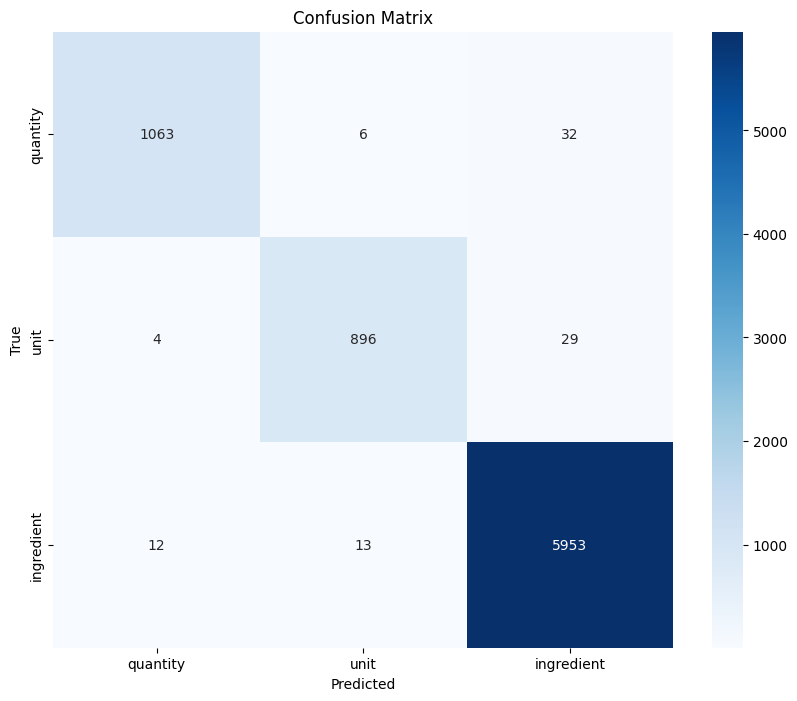

In [182]:
# create a confusion matrix on training datset
def create_confusion_matrix(y_true, y_pred, labels):
    """
    Create a confusion matrix for the given true and predicted labels.
    
    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        labels (list): List of unique labels.
        
    Returns:
        np.ndarray: Confusion matrix.
    """
    return confusion_matrix(y_true, y_pred, labels=labels)
# Create confusion matrix for training dataset
train_confusion_matrix = create_confusion_matrix(y_train_true_flat, y_train_pred_flat,
                                                 labels=list(train_label_counts.keys()))
# Display confusion matrix
def display_confusion_matrix(confusion_matrix, labels): 
    """
    Display the confusion matrix using seaborn heatmap.
    
    Args:
        confusion_matrix (np.ndarray): Confusion matrix to display.
        labels (list): List of unique labels.
        
    Returns:
        None
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
# Display confusion matrix for training dataset
display_confusion_matrix(train_confusion_matrix, list(train_label_counts.keys()))
# Print classification report for training dataset
def print_classification_report(y_true, y_pred, labels):
    """
    Print classification report for the given true and predicted labels.
    
    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        labels (list): List of unique labels.
        
    Returns:
        None
    """
    report = flat_classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n", report)



### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [183]:
# dump the model using joblib as crf_model.pkl
def save_crf_model(crf_model, file_path='crf_model.pkl'):
    """
    Save the trained CRF model to a file.
    
    Args:
        crf_model (sklearn_crfsuite.CRF): Trained CRF model.
        file_path (str): Path to save the model file.
        
    Returns:
        None
    """
    joblib.dump(crf_model, file_path)
# Save the trained CRF model
save_crf_model(crf_model)

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [184]:
# predict the crf model on validation dataset
y_val_pred = evaluate_crf_model(crf_model, X_val_weighted_features, y_val_labels)



In [185]:
# specify flat classification report
y_val_true_flat = flatten_labels(y_val_labels)
y_val_pred_flat = flatten_labels(y_val_pred)

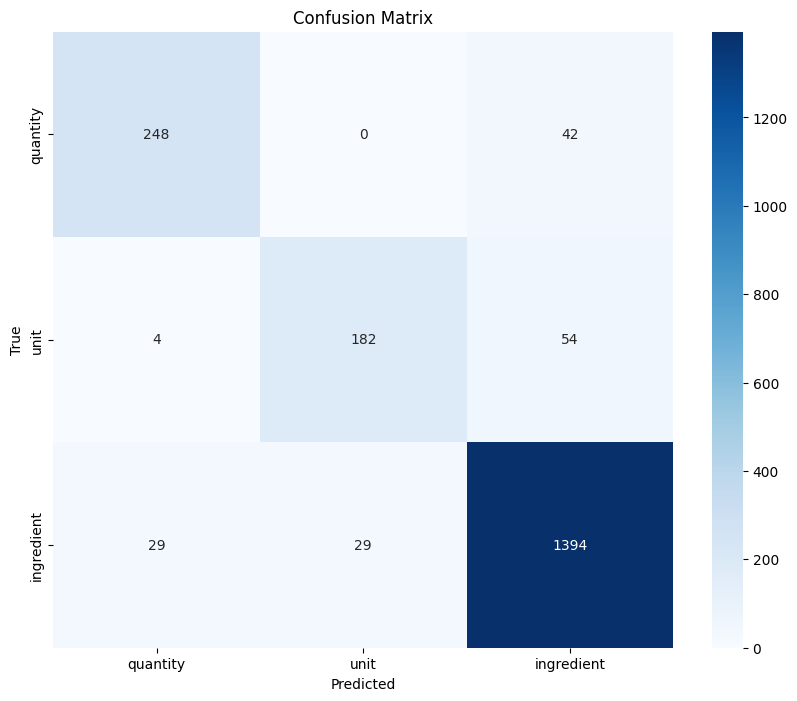

In [186]:
# create a confusion matrix on validation dataset

val_confusion_matrix = create_confusion_matrix(y_val_true_flat, y_val_pred_flat,
                                              labels=list(val_label_counts.keys()))
# Display confusion matrix for validation dataset
display_confusion_matrix(val_confusion_matrix, list(val_label_counts.keys()))

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [187]:
# flatten Labels and Initialise Error Data
y_val_true_flat = flatten_labels(y_val_labels)
y_val_pred_flat = flatten_labels(y_val_pred)

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [188]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
def collect_error_info(y_true, y_pred, tokens):
    """
    Collect error information by comparing true and predicted labels.
    
    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        tokens (list): List of tokenized sentences.
        
    Returns:
        list: List of dictionaries containing error information.
    """
    errors = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            error_info = {
                'token': tokens[i],
                'true_label': y_true[i],
                'predicted_label': y_pred[i],
                'previous_token': tokens[i-1] if i > 0 else None,
                'next_token': tokens[i+1] if i < len(tokens) - 1 else None
            }
            errors.append(error_info)
    return errors
# Collect error information for validation dataset
val_errors = collect_error_info(y_val_true_flat, y_val_pred_flat, flatten_list(val_input_tokens))

In [189]:
# predict this "2 cups of flour"
def predict_tokens(crf_model, input_text):
    """
    Predict tokens and their POS tags using the trained CRF model.
    
    Args:
        crf_model (sklearn_crfsuite.CRF): Trained CRF model.
        input_text (str): Input text to predict tokens for.
        
    Returns:
        list: List of predicted labels for each token in the input text.
    """
    # Tokenize the input text
    doc = nlp(input_text)
    tokens = [token.text for token in doc]
    
    # Convert tokens to features
    features = convert_to_features([tokens])
    
    # Predict labels using the CRF model
    predicted_labels = crf_model.predict(features)[0]
    
    return list(zip(tokens, predicted_labels))
# Predict tokens for the input text "2 cups of flour"
input_text = "2 cups of flour"
predicted_tokens = predict_tokens(crf_model, input_text)
# Display the predicted tokens and their labels
print("Predicted Tokens:")
for token, label in predicted_tokens:
    print(f"{token}: {label}")

Predicted Tokens:
2: quantity
cups: unit
of: ingredient
flour: ingredient


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [190]:
# Create DataFrame and Print Overall Accuracy

val_errors_df = pd.DataFrame(val_errors)
val_errors_df.to_csv("val_errors.csv", index=False)
print("Validation Errors DataFrame:")
print(val_errors_df.head())

Validation Errors DataFrame:
      token  true_label predicted_label previous_token next_token
0       Til  ingredient        quantity          seeds   teaspoon
1  teaspoon        unit      ingredient            Til        Red
2    powder  ingredient            unit            Red      Cumin
3       1/2    quantity      ingredient         Dhania      Garam
4         2    quantity      ingredient         masala      Sweet


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [191]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
def analyze_errors(errors_df, class_weights):
    """
    Analyze errors found in the validation data.
    
    Args:
        errors_df (pd.DataFrame): DataFrame containing error information.
        class_weights (dict): Dictionary of class weights.
        
    Returns:
        None
    """
    print("Error Analysis:")
    print(errors_df[['token', 'previous_token', 'next_token', 'true_label', 'predicted_label']])
    
    # Calculate accuracy
    accuracy = (errors_df['true_label'] == errors_df['predicted_label']).mean()
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Display class weights
    print("Class Weights:")
    for label, weight in class_weights.items():
        print(f"{label}: {weight:.4f}")
# Analyze errors in validation dataset
analyze_errors(val_errors_df, val_class_weights)
   


Error Analysis:
           token previous_token next_token  true_label predicted_label
0            Til          seeds   teaspoon  ingredient        quantity
1       teaspoon            Til        Red        unit      ingredient
2         powder            Red      Cumin  ingredient            unit
3            1/2         Dhania      Garam    quantity      ingredient
4              2         masala      Sweet    quantity      ingredient
..           ...            ...        ...         ...             ...
153         slit       Chillies     Cloves  ingredient        quantity
154         inch     Pods/Seeds   Cinnamon        unit      ingredient
155  tablespoons           Salt       Ghee        unit      ingredient
156          bud             10     garlic        unit      ingredient
157        green              2   chillies        unit      ingredient

[158 rows x 5 columns]
Overall Accuracy: 0.0000
Class Weights:
quantity: 2.2782
unit: 2.7528
ingredient: 0.4550


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




In [192]:
# Display the first few rows of the error DataFrame
print("First few rows of the error DataFrame:")
print(val_errors_df.head())
# Display the overall accuracy of the model on the validation dataset
import numpy as np
overall_accuracy = np.mean(np.array(y_val_true_flat) == np.array(y_val_pred_flat))
print(f"Overall Accuracy on Validation Dataset: {overall_accuracy:.4f}")
# Display the class weights used in the model
print("Class Weights:")
for label, weight in val_class_weights.items():
    print(f"{label}: {weight:.4f}")
# Display the first few rows of the error DataFrame
print("First few rows of the error DataFrame:")
print(val_errors_df.head())
# Display the number of errors found in the validation dataset
print(f"Number of errors found in the validation dataset: {len(val_errors_df)}")
# Display the number of unique labels in the validation dataset
print(f"Number of unique labels in the validation dataset: {len(val_label_counts)}") 

First few rows of the error DataFrame:
      token  true_label predicted_label previous_token next_token
0       Til  ingredient        quantity          seeds   teaspoon
1  teaspoon        unit      ingredient            Til        Red
2    powder  ingredient            unit            Red      Cumin
3       1/2    quantity      ingredient         Dhania      Garam
4         2    quantity      ingredient         masala      Sweet
Overall Accuracy on Validation Dataset: 0.9203
Class Weights:
quantity: 2.2782
unit: 2.7528
ingredient: 0.4550
First few rows of the error DataFrame:
      token  true_label predicted_label previous_token next_token
0       Til  ingredient        quantity          seeds   teaspoon
1  teaspoon        unit      ingredient            Til        Red
2    powder  ingredient            unit            Red      Cumin
3       1/2    quantity      ingredient         Dhania      Garam
4         2    quantity      ingredient         masala      Sweet
Number of errors fo

 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.